## Overoptimism considering the random seed

Here we try the two moons dataset with 100 different random seeds to 
show how much ROCK depends on random seeds compared to the other algorithms.

In [1]:
import sys  
sys.path.insert(0, '../../')

In [2]:
import optuna
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score as AMI
from rock import ROCK

import logging
import sys
from tqdm.notebook import tqdm

In [3]:
seed = 0
n_samples = 1000
jitter = 5 * 0.01
datasets = []
experiment = []

In [ ]:
for s in tqdm(range(seed, seed+100)):
    dataset = make_moons(n_samples=n_samples, noise=jitter, shuffle=True, random_state=s) 
    run = {}
    run['seed'] = seed
    run['n_samples'] = n_samples
    run['jitter'] = jitter
    scaler = StandardScaler()
    data = scaler.fit_transform(dataset[0])
    kmeans = KMeans(n_clusters=2, random_state=seed).fit(data).labels_
    run['k'] = 2
    eps, min_pts = (0.2, 4)
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(data).labels_
    run['eps'] = eps
    run['min_pts'] = min_pts
    spectral = SpectralClustering(n_clusters=2, random_state=seed).fit(data).labels_
    bandwidth = estimate_bandwidth(data)

    run['bandwidth'] = bandwidth
    mean_shift = MeanShift(bandwidth=bandwidth).fit(data).labels_

    rock = ROCK(tmax=15).fit(data).labels_

    gt = dataset[1]

    run['ROCK'] = AMI(rock, gt)
    run['K_MEANS'] = AMI(kmeans, gt)
    run['DBSCAN'] = AMI(dbscan, gt)
    run['SPECTRAL'] = AMI(spectral, gt)
    run['MEAN_SHIFT'] = AMI(mean_shift, gt)

    experiment.append(run)

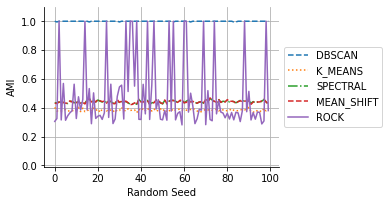

In [5]:
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['figure.figsize'] = (14*0.393701, 7.5*0.393701)

mean_std = pd.DataFrame(experiment)[['ROCK', 'K_MEANS', 'DBSCAN', 'SPECTRAL', 'MEAN_SHIFT']]

plt.plot(mean_std.index, mean_std['DBSCAN'], linestyle='--', label='DBSCAN')
plt.plot(mean_std.index, mean_std['K_MEANS'], linestyle=":", label='K_MEANS')
plt.plot(mean_std.index, mean_std['SPECTRAL'], linestyle='-.', label='SPECTRAL')
plt.plot(mean_std.index, mean_std['MEAN_SHIFT'], linestyle='--', label='MEAN_SHIFT')
plt.plot(mean_std.index, mean_std['ROCK'], linestyle='-',  label='ROCK')


plt.ylim(-0.01, 1.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Random Seed')
plt.ylabel('AMI')
plt.tight_layout()
plt.savefig('../../figures/two_moons_analysis_100_seeds.png', dpi = 600, bbox_inches='tight')